<a href="https://colab.research.google.com/github/rumeysaakbas/NeuralNetworks/blob/main/ysa_s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import time


# Veri setini yükle
train_df = pd.read_csv("cure_the_princess_train.csv")
test_df = pd.read_csv("cure_the_princess_test.csv")
val_df = pd.read_csv("cure_the_princess_validation.csv")

# Hedef sütunu etiket olarak ayır
train_labels = train_df['Cured'].values
train_df = train_df.drop('Cured', axis=1)
test_labels = test_df['Cured'].values
test_df = test_df.drop('Cured', axis=1)
val_labels = val_df['Cured'].values
val_df = val_df.drop('Cured', axis=1)

# Girdi özelliklerini normalize edin
scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.fit_transform(test_df)
val_df = scaler.fit_transform(val_df)

# Verileri PyTorch tensor'larına dönüştürün
X_train = torch.Tensor(train_df)
y_train = torch.Tensor(train_labels)
X_test = torch.Tensor(test_df)
y_test = torch.Tensor(test_labels)
X_val = torch.Tensor(val_df)
y_val = torch.Tensor(val_labels)

# Tensor'ları birleştirin
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

# Trainloader'ı oluşturun
batch_size = 32
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)



In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size)
        self.bn1 = nn.BatchNorm1d(h1_size)
        self.fc2 = nn.Linear(h1_size, h2_size)
        self.bn2 = nn.BatchNorm1d(h2_size)
        self.fc3 = nn.Linear(h2_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.8)
        
    def forward(self, input_layer):
        hidden_layer1 = self.dropout(self.relu(self.bn1(self.fc1(input_layer))))
        hidden_layer2 = self.dropout(self.relu(self.bn2(self.fc2(hidden_layer1))))
        output_layer = self.sigmoid(self.fc3(hidden_layer2))
        return output_layer


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Training loss 0.36875796839594843 Validation Loss : 0.2506861060857773
Epoch 1 Training loss 0.351004920899868 Validation Loss : 0.2507523223757744
Epoch 2 Training loss 0.350387866795063 Validation Loss : 0.25056711584329605
Epoch 3 Training loss 0.3458912745118141 Validation Loss : 0.2505014851689339
Epoch 4 Training loss 0.3445174306631088 Validation Loss : 0.2508497595787048
Epoch 5 Training loss 0.34339201301336286 Validation Loss : 0.2520110487937927
Epoch 6 Training loss 0.3369668237864971 Validation Loss : 0.2517662763595581
Epoch 7 Training loss 0.32744994312524794 Validation Loss : 0.2535833135247231
Epoch 8 Training loss 0.3255854368209839 Validation Loss : 0.2552816778421402
Epoch 9 Training loss 0.31823914051055907 Validation Loss : 0.2602248668670654
Epoch 10 Training loss 0.3229566507041454 Validation Loss : 0.2649630606174469
Epoch 11 Training loss 0.308175378292799 Validation Loss : 0.26424236595630646
Epoch 12 Training loss 0.29779893793165685 Validation Loss 

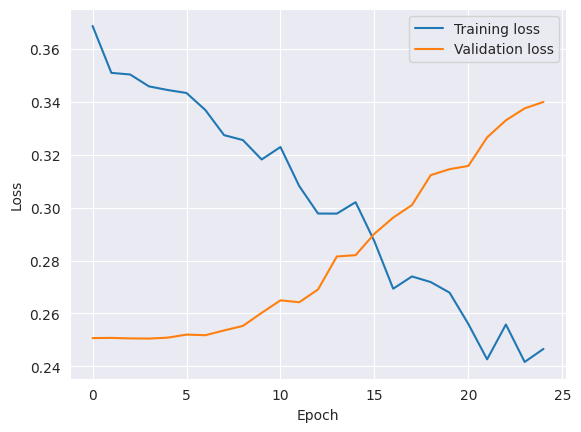

Finished Training
--- 6.441974639892578 saniye ---


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
baslangic_zamani = time.time()

torch.manual_seed(190401003)

input_size = train_df.shape[1]
h1_size = 100
h2_size = 50
output_size = 1
lr = 0.001
patience_counter = 0
patience = 5

num_epochs = 25
list_train_loss, list_val_loss = [], []
best_val_loss = None

# Modeli cihaz üzerinde eğitin
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size, h1_size, h2_size, output_size).to(device)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Train the model
for epoch in range(num_epochs):

    # training loop
    train_loss = 0.0
    train_count = 0.0
    for X_train, y_train in trainloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(X_train.to(device))
        loss = criterion(outputs, y_train.to(device).unsqueeze(1))
        loss += 0.5 * 0.001 * sum([torch.sum(param ** 2) for param in model.parameters()])
        loss.backward()
        optimizer.step()
        train_count += 1.0
        train_loss += loss.item()

    val_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, y_val in valloader:
            outputs = model(X_val.to(device))
            loss = criterion(outputs, y_val.to(device))
            #validation_count += 1.0
            val_loss += loss.item()
    model.train()

    # calculate metrics
    train_loss /= train_count
    val_loss /= len(valloader)
    #val_acc = 100 * val_correct / val_total

    print("Epoch", epoch, "Training loss", train_loss,"Validation Loss :",val_loss)

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    '''val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0'''

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


print('Finished Training')

print("--- %s saniye ---" % (time.time() - baslangic_zamani))

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model(X_test.to(device))
y_pred = torch.argmax(y_pred, dim=1)

cm = confusion_matrix(y_test.to(device), y_pred)
cr = classification_report(y_test.to(device), y_pred)

print("Confusion matrix:")
print(cm)
print("\nClassification report:")
print(cr)